# densepose convert demo

In [1]:
from UVTextureConverter import Normal2Atlas
from UVTextureConverter import Atlas2Normal
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

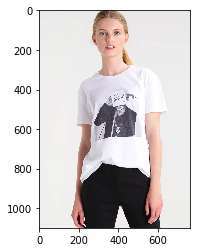

In [2]:
im = Image.open("../input/human.jpg")
plt.imshow(im)

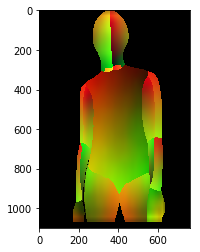

In [3]:
iuv = Image.open("../input/human_IUV.jpg")
plt.imshow(iuv)

## get texture by densepose in atlas style

In [4]:
def crop_center(pil_img, crop_width, crop_height):
    img_width, img_height = pil_img.size
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))

def create_smpl_from_images(im, iuv, img_size=200, entire=True, parts_type=0, resize=None):  
    I_id, U_id, V_id = 2, 1, 0
    if entire:
        parts_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24] # 22
        parts_num = 24
    else:
        if parts_type==0:
            parts_list = [1, 2, 15, 16, 17, 18, 19, 20, 21, 22] # 10
            parts_num = 10
        elif parts_type==1:
            parts_list = [1, 2, 3, 4, 15, 16, 17, 18, 19, 20, 21, 22] # 12
            parts_num = 12

    ### generate parts ###
    im = Image.open(im)
    iuv = Image.open(iuv)
    
    if not resize is None:
        im = crop_center(im.resize((192, int(192*1100/762))), 192, 256)
        iuv = crop_center(iuv.resize((192, int(192*1100/762))), 192, 256)

    im = (np.array(im) / 255).transpose(2,1,0)
    iuv = (np.array(iuv)).transpose(2,1,0)

    texture = np.zeros((parts_num, 3, img_size, img_size))
    mask = np.zeros((parts_num, img_size, img_size))
    for j, parts_id in enumerate(parts_list):
        im_gen = np.zeros((3, img_size, img_size))
        im_gen[0][(iuv[V_id][iuv[I_id] == parts_id] / 255 * (img_size-1)).astype(int), (iuv[U_id][iuv[I_id] == parts_id] / 255 * (img_size-1)).astype(int)] = im[0][iuv[I_id] == parts_id]
        im_gen[1][(iuv[V_id][iuv[I_id] == parts_id] / 255 * (img_size-1)).astype(int), (iuv[U_id][iuv[I_id] == parts_id] / 255 * (img_size-1)).astype(int)] = im[1][iuv[I_id] == parts_id]
        im_gen[2][(iuv[V_id][iuv[I_id] == parts_id] / 255 * (img_size-1)).astype(int), (iuv[U_id][iuv[I_id] == parts_id] / 255 * (img_size-1)).astype(int)] = im[2][iuv[I_id] == parts_id]
        texture[j] = im_gen[:,::-1, :]

        mask[j][(iuv[V_id][iuv[I_id] == parts_id] / 255 * (img_size-1)).astype(int), (iuv[U_id][iuv[I_id] == parts_id] / 255 * (img_size-1)).astype(int)] =  1
        mask[j] = mask[j][::-1, :]

    return texture, mask

In [5]:
parts_size = 200
tex, mask = create_smpl_from_images("../input/human.jpg", "../input/human_IUV.jpg", img_size=parts_size)

In [6]:
tex_trans = np.zeros((24, parts_size, parts_size, 3))
mask_trans = np.zeros((24, parts_size, parts_size))
for i in range(tex.shape[0]):
    tex_trans[i] = tex[i].transpose(2, 1, 0)
    mask_trans[i] = mask[i].transpose(1, 0)

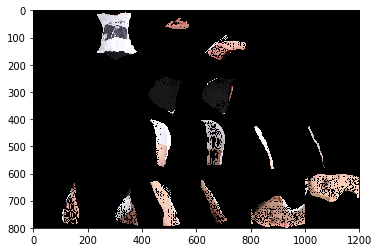

In [7]:
plt.imshow(Normal2Atlas.concat_atlas_tex(tex_trans))

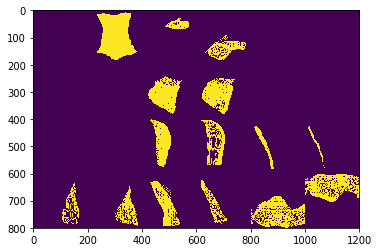

In [8]:
plt.imshow(Normal2Atlas.concat_atlas_tex(mask_trans))

## convert from atlas to normal

In [9]:
converter = Atlas2Normal(atlas_size=parts_size, normal_size=512)
normal_tex, normal_ex = converter.convert((tex_trans*255).astype('int'), mask=mask_trans)

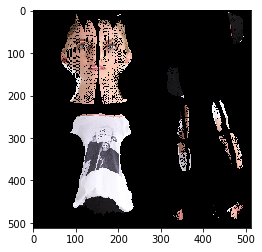

In [10]:
plt.imshow(normal_tex)

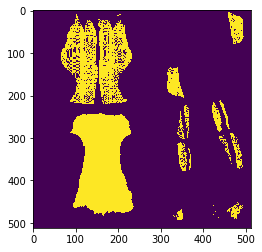

In [11]:
plt.imshow(normal_ex)

## reverse demo (convert from normal to atlas)

In [12]:
converter = Normal2Atlas(atlas_size=parts_size, normal_size=512)
atlas_tex, atlas_ex = converter.convert((normal_tex*255).astype('int'), normal_ex)

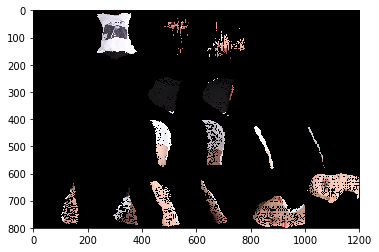

In [13]:
plt.imshow(Normal2Atlas.concat_atlas_tex(atlas_tex))

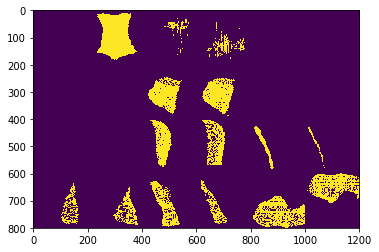

In [14]:
plt.imshow(Normal2Atlas.concat_atlas_tex(atlas_ex))